This notebook is designed to show the properties of the Lane-Emden equation for interger values of n. The equation is solved by a 4th order Runge-Kutta solver, while the roots of the Lane-Emden functions where determined using a Newton-Raphson solver

In the first block, we import the required libraries

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, display, Math
import tabulate
import warnings

We define the classes necessary to carry out the Runge-Kutta 4th order integration. runkutt is the integrater and the g function will update the function and the first derivative

In [25]:
def runkutt(y,t,dt,n):
#The method implemented is the one described in An Introduction to Computational Physics, 2nd Edition
# by Tao Pang    
    c1 = np.zeros(2)
    c2 = np.zeros(2)
    c3 = np.zeros(2)
    c4 = np.zeros(2)
  
    c1 = g(y,t,n)
    
    c2 = y + dt*c1/2
    c2 = g(c2,t+dt/2,n)
    
    c3 = y + dt*c2/2
    c3 = g(c3,t+dt/2,n)
    
    c4 = y + dt*c3/2 
    c4 = g(c4,t+dt/2,n)
    
    return y + dt*(c1 + 2*(c2+c3) +c4)/6
    

def g(y,t,n):
# updates the function and the first derivative    
    v = np.zeros(2)
    
    v[0] = -y[1]/t**2
    v[1] = (y[0]**n)*t**2
    
    return v

The Newton-Raphson method is used to calculate the 1st roots of the polytrope

In [26]:
def newton_raphson(x,y,dy,x0,j):
# since we on't have an explicit function, we need to interpolate the data at every new "root"
# until convergence. 
    h = y[j]/dy[j]
    while abs(h) >=1e-10:
        x0 -= h
        y0  = np.interp(x0,x,y)
        dy0 = np.interp(x0,x,dy)
        h   = y0/dy0
    return x0

This block calls the Runge-Kutta solver applied to the Lane-Embden equations for integer index from 0 to 5.

In [27]:
warnings.filterwarnings("ignore")
m    = 10000
dt   = 20/m
table = np.empty((5,3))
poly_temp = np.empty((m,6))
dim_less_rad = np.zeros(m)

roots = np.empty(5)
d_theta_1 = np.empty(5)
for i in range(m):
    dim_less_rad[i] = dt*(i+1)
for n in range(0,6):
        
    y1 = np.zeros(m)
    y2 = np.zeros(m)
    
    y  = np.zeros(2)
    y[0] = 1
    y[1] = 0
    
    y1[0] = y[0]
    y2[0] = y[1]
        
    for i in range (m):
        
        y     = runkutt(y,dim_less_rad[i],dt,n)
        y1[i] = y[0]
        y2[i] = y[1]
        poly_temp[i,n] = y1[i]
            
    
    if n!=5:
       dy = np.gradient(y1,dt)          
       i = 0
       for i in range(m):
           if y1[i] < 0:
              break            

       t0 = dim_less_rad[i-1]
       t1 = newton_raphson(dim_less_rad,y1,dy,t0,i-1)
       roots[n] = t1
       d_theta_1[n] = abs(np.interp(t1,dim_less_rad,dy))      
       table[n] = [n,t1,d_theta_1[n]]

We graph the solutions of the Lane-Emden equation, with the roots marked, and the important properties tabulated

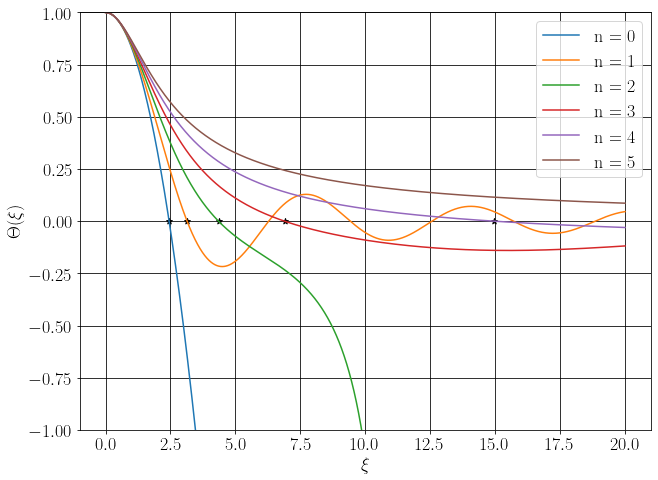

<IPython.core.display.Math object>

0,2.44816,0.816496
1,3.13976,0.318476
2,4.35017,0.127342
3,6.89194,0.0424747
4,14.9565,0.00803214


In [28]:
plt.figure(figsize=(10.24,7.68))
plt.xlabel(r'$\xi$')
plt.ylabel(r'$\Theta(\xi)$')
plt.ylim([-1,1])
plt.rc('text', usetex=True)
plt.rc('font', family = 'serif')
plt.rcParams['font.size']=18
plt.grid(color = 'black')
roots_ordinate = np.zeros(np.size(roots)) 
for i in range(0,6):
    plt.plot(dim_less_rad,poly_temp[:,i],label = 'n = '+str(i))
plt.scatter(roots,roots_ordinate,marker='*',color='black')

plt.legend()
plt.show()

display(Math(r'n  \;\;\;\;\;  \xi_{1}   \;\;\;\;\; -\frac{d\theta}{d\xi}\Bigr|_{\xi=\xi_{1}}'))
display(HTML(tabulate.tabulate(table, tablefmt='html')))

To extract the measurable physics from the solutions, we need to specify the central pressure and density, as well the K factor (units are in S.I). Since the star actually reaches it's maximal radius at the 1st root of the Lane_Emden equation

In [34]:
M = 1 #total mass in solar
n = 3 #polytropic index [select integer from 0 to 5]
rho_c = 1e+13 #central density

m_sun = 1.989e+30
r_sun = 6.957e+8

M_total = M*m_sun
G = 6.67408e-11
#calculating K
term1 = 4*np.pi*G/(n+1)
term2 = M_total/(4*np.pi)
term3 = np.power(rho_c,(3-n)/(2*n))
term4 = np.power(roots[n],2)*d_theta_1[n]
K = term1*np.power(term2/(term3*term4),2/3)


P_c   = K*np.power(rho_c,1+1/n)

alpha = np.sqrt(K*(n+1)*np.power(rho_c,1/n - 1)/(4*np.pi*G))

#solve for the extent to cut off the arrays
limit = np.where(np.abs(dim_less_rad-roots[n])<1e-2)[0]

dummy_1 = dim_less_rad[0:limit[0]]
dummy_2 = poly_temp[0:limit[0],n+1]
dummy_3 = poly_temp[0:limit[0],n]

dm_lss_rd = np.append(dummy_1,roots[n])
pl_tmp = np.append(dummy_2,0)
pl_tmp_dense = np.append(dummy_3,0)
rad = alpha*dm_lss_rd
P = P_c*pl_tmp

rho = rho_c*pl_tmp_dense

#integrating continuity equation to get the mass via euler technique. We know the mass at R = 0 is 0, so that's the boundary condition
mass = np.empty(len(rad))
mass[0] = 0
for i in range(0,len(mass)-1):
    mass[i+1] = mass[i] + 4*np.pi*rho[i]*np.power(rad[i],2)*(rad[i+1]-rad[i])

Plotting the good stuff

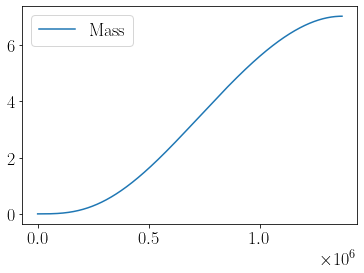

In [38]:
plt.figure()
plt.plot(rad,mass/m_sun,label='Mass')

plt.legend()
plt.show()

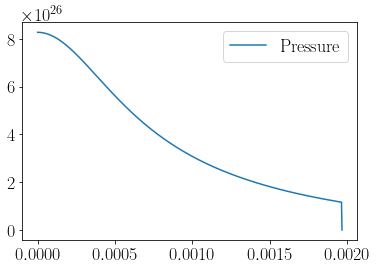

In [36]:
plt.figure()
plt.plot(rad/r_sun,P,label='Pressure')

plt.legend()
plt.show()

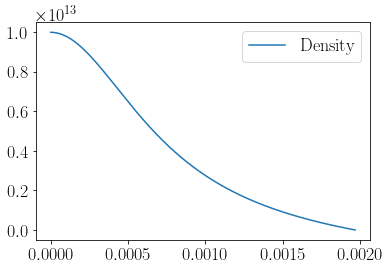

In [37]:
plt.figure()
plt.plot(rad/r_sun,rho,label='Density')
plt.legend()
plt.show()